CLIP DEBIASING

-------------------------------- ANALYSIS AND BASELINE ---------------------------------------

Configuration

In [1]:
# %% [markdown]
# CLIP DEBIASING

# %% [markdown]
# -------------------------------- ANALYSIS AND BASELINE ---------------------------------------

# %% [markdown]
# Configuration

# %%
import os, random, math, json, time
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Device: preferisci MPS su Mac, fallback a CUDA/CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)

# Riproducibilità leggera
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); 
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# Config generale (modifica liberamente)
CONFIG = {
    "paths": {
        "fairface_root": "./dataset/bias/fairface-img-margin025-trainval/train",  
        "fairface_val_root": "./dataset/bias/fairface-img-margin025-trainval/val",
        "fairface_csv": "./dataset/bias/fairface-img-margin025-trainval/annotation/fairface_label_train.csv",
        "fairface_csv_val": "./dataset/bias/fairface-img-margin025-trainval/annotation/fairface_label_val.csv",
        "outdir": "./outputs_baseline",
    },
    "clip": {
        "variant": "ViT-B-32",
        "pretrained": "openai",
        "image_resolution": 224,
    },
    "fairface": {
        "max_images_per_group": 1200,     # per velocizzare baseline
        "num_workers": 4,
        "batch_size": 64,
        "races": ["White","Black","East Asian","Southeast Asian","Indian","Middle Eastern","Latino_Hispanic"],
        "genders": ["Male","Female"],     # estendibile
        "exclude_unknown": True,
    },
    "pets": {
        "pets_root": "./dataset/zero/data",
        "batch_size": 64,
        "num_workers": 4,
    },
    "prompts": {
        "neutral_ratio": 0.20,  # ~20% neutrali
        "professions": [
            "nurse","software engineer","CEO","model","surgeon","teacher",
            "police officer","janitor","driver","scientist","receptionist",
            "chef","cashier","professor","lawyer","mechanic","artist",
            "soldier","banker","journalist","farmer","designer","pilot",
            "bartender","coach","plumber","writer","photographer","dentist",
            "pharmacist","electrician","architect","physicist","data analyst",
            "manager","accountant","firefighter","waiter","musician","actor",
            "dancer","doctor","paramedic","veterinarian","construction worker",
            "psychologist","librarian","social worker","hairdresser","security guard"
        ],
        "gender_tokens": {"Male":"male","Female":"female"},
        "race_tokens": {
            "White":"white", "Black":"black", "East Asian":"east asian",
            "Southeast Asian":"southeast asian", "Indian":"indian",
            "Middle Eastern":"middle eastern", "Latino_Hispanic":"latino"
        },
        "templates_sensitive": [
            #"a photo of a {gender} {race} {profession}",
            #"a photo of a {race} {gender} {profession} person",
            #"a portrait of a {gender} {race} {profession}"
                        # Profession / Status bias
            "a photo of a {gender} {race} doctor",
            "a photo of a {gender} {race} nurse",
            "a photo of a {gender} {race} teacher",
            "a photo of a {gender} {race} CEO",
            "a photo of a {gender} {race} engineer",
            "a photo of a {gender} {race} janitor",
            "a photo of a {gender} {race} scientist",
            "a photo of a {gender} {race} model",
            "a photo of a {gender} {race} police officer",
            "a photo of a {gender} {race} housekeeper",
            # Emotion bias
            "a {gender} {race} person smiling",
            "a {gender} {race} person angry",
            "a {gender} {race} person sad",
            "a {gender} {race} person laughing",
            "a {gender} {race} person crying",
            "a {gender} {race} person shouting",
            "a {gender} {race} person serious",
            # Appearance / Attractiveness bias
            "a photo of a {gender} {race} person wearing makeup",
            "a {gender} {race} person wearing a suit",
            "a {gender} {race} person wearing a dress",
            "a {gender} {race} person with glasses",
            "a {gender} {race} person with tattoos",
            "a beautiful {gender} {race} person",
            "an ugly {gender} {race} person",
            # Socioeconomic / Context bias
            "a {gender} {race} person in a luxury office",
            "a {gender} {race} person cleaning a house",
            "a {gender} {race} person working on a construction site",
            "a {gender} {race} person shopping in a mall",
            "a {gender} {race} person driving a taxi",
            "a {gender} {race} person cooking in a kitchen",
            "a {gender} {race} homeless person",
            "a rich {gender} {race} person"
        ],
        "templates_neutral": [
            "a photo of a person working as {profession}",
            "a portrait of a {profession}",
            "a photo of a {profession} at work"
        ],
    },
    "pca": {
        "update_every_epochs": 2,  # baseline: calcolo iniziale; utile poi per FT
        "components_per_axis": 1    # k=1 per stabilità e costo
    }
}

# === COCO ADDITION START: CONFIG ===
CONFIG["paths"]["coco_root"] = "dataset/data_utils/coco/"
CONFIG["paths"]["coco_ann_train"] = "dataset/data_utils/coco/annotations_train.csv"
CONFIG["paths"]["coco_ann_val"] = "dataset/data_utils/coco/annotations_val.csv"
CONFIG["coco"] = {
    "train_dir": "dataset/data_utils/coco/train/",
    "val_dir": "dataset/data_utils/coco/val/",
    "batch_size": 16,
    "num_workers": 0,
    "max_images": 8500,
    "person_only": True
}
# === COCO ADDITION END: CONFIG ===

os.makedirs(CONFIG["paths"]["outdir"], exist_ok=True)
print(json.dumps(CONFIG, indent=2))


Device: mps
{
  "paths": {
    "fairface_root": "./dataset/bias/fairface-img-margin025-trainval/train",
    "fairface_val_root": "./dataset/bias/fairface-img-margin025-trainval/val",
    "fairface_csv": "./dataset/bias/fairface-img-margin025-trainval/annotation/fairface_label_train.csv",
    "fairface_csv_val": "./dataset/bias/fairface-img-margin025-trainval/annotation/fairface_label_val.csv",
    "outdir": "./outputs_baseline",
    "coco_root": "dataset/data_utils/coco/",
    "coco_ann_train": "dataset/data_utils/coco/annotations_train.csv",
    "coco_ann_val": "dataset/data_utils/coco/annotations_val.csv"
  },
  "clip": {
    "variant": "ViT-B-32",
    "pretrained": "openai",
    "image_resolution": 224
  },
  "fairface": {
    "max_images_per_group": 1200,
    "num_workers": 4,
    "batch_size": 64,
    "races": [
      "White",
      "Black",
      "East Asian",
      "Southeast Asian",
      "Indian",
      "Middle Eastern",
      "Latino_Hispanic"
    ],
    "genders": [
      "M

In [2]:

# %% [markdown]
# CLIP Configuration

# %%
import open_clip

clip_model_name = CONFIG["clip"]["variant"]
pretrained_tag = CONFIG["clip"]["pretrained"]

model, _, preprocess = open_clip.create_model_and_transforms(
    clip_model_name,
    pretrained=pretrained_tag,
    device=device
)
tokenizer = open_clip.get_tokenizer(clip_model_name)
model.eval()  # baseline: nessun training qui

# congeliamo esplicitamente tutto
for p in model.parameters():
    p.requires_grad = False

print("CLIP loaded:", clip_model_name, "/", pretrained_tag)


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


CLIP loaded: ViT-B-32 / openai


DATASET

FAIRFACE

In [3]:

# %% [markdown]
# Dataset FairFace (bias analysis) + DataLoader

# %%
import pandas as pd
pd.read_csv(CONFIG["paths"]["fairface_csv_val"]).columns


# %%
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os

class FairFaceDataset(Dataset):
    """
    Richiede un CSV con colonne: file, gender, race
    - `file` relativo a fairface_root o assoluto
    - gender ∈ CONFIG["fairface"]["genders"]
    - race ∈ CONFIG["fairface"]["races"] (o 'Unknown' che possiamo escludere)
    """
    def __init__(self, root: str, csv_path: str, transform, genders, races, exclude_unknown=True, max_per_group=None):
        self.root = root
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.genders = set(genders)
        self.races = set(races)

        if exclude_unknown:
            self.df = self.df[(self.df["gender"].isin(self.genders)) & (self.df["race"].isin(self.races))]

        # Balancing semplice per non esplodere in tempo:
        if max_per_group is not None:
            rows = []
            for g in sorted(self.genders):
                for r in sorted(self.races):
                    sub = self.df[(self.df.gender == g) & (self.df.race == r)]
                    if len(sub) > max_per_group:
                        sub = sub.sample(max_per_group, random_state=42)
                    rows.append(sub)
            self.df = pd.concat(rows) if rows else self.df
            self.df = self.df.sample(frac=1.0, random_state=42).reset_index(drop=True)

        # --- Costruisci path assoluti (con fix per doppioni "val/val" o "train/train") ---
        self.paths = []
        for p in self.df["file"].tolist():
            norm_p = p.lstrip("./")  # rimuove eventuale ./ iniziale
            # se nel CSV c'è già "train/" o "val/", eviti di ripeterlo
            if norm_p.startswith("train/") or norm_p.startswith("val/"):
                norm_p = os.path.basename(norm_p)
            full_path = p if os.path.isabs(norm_p) else os.path.join(root, norm_p)
            self.paths.append(full_path)

        self.genders_list = self.df["gender"].tolist()
        self.races_list = self.df["race"].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        x = self.transform(img)
        return x, self.genders_list[idx], self.races_list[idx]


# Instantiate
ff_cfg = CONFIG["fairface"]
fairface_ds = FairFaceDataset(
    root=CONFIG["paths"]["fairface_val_root"],
    csv_path=CONFIG["paths"]["fairface_csv_val"],
    transform=preprocess,
    genders=ff_cfg["genders"],
    races=ff_cfg["races"],
    exclude_unknown=ff_cfg["exclude_unknown"],
    max_per_group=ff_cfg["max_images_per_group"]
)

fairface_loader = DataLoader(
    fairface_ds,
    batch_size=ff_cfg["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type != "cpu")
)

len(fairface_ds)

# %% [markdown]
# Prompt Bank con Parity & 20% neutrali

# %%
# %% [markdown]
# # Step 3 — Prompt Bank con parity (gender, race) + 20% neutrali


10954

In [4]:

# %%
def build_prompt_bank(cfg_prompts, genders_avail, races_avail):
    profs = cfg_prompts["professions"]
    gtok = cfg_prompts["gender_tokens"]
    rtok = cfg_prompts["race_tokens"]
    ts = cfg_prompts["templates_sensitive"]
    tn = cfg_prompts["templates_neutral"]
    neutral_ratio = cfg_prompts["neutral_ratio"]

    sensitive_prompts = []
    for p in profs:
        for g in genders_avail:
            for r in races_avail:
                gword = gtok[g]
                rword = rtok[r]
                for tmpl in ts:
                    sensitive_prompts.append(tmpl.format(gender=gword, race=rword, profession=p))

    neutral_prompts = []
    for p in profs:
        for tmpl in tn:
            neutral_prompts.append(tmpl.format(profession=p))

    # Combinazione: includi neutrali ~20% rispetto ai sensitive
    target_neutral = int(len(sensitive_prompts) * neutral_ratio)
    if target_neutral < len(neutral_prompts):
        rng = np.random.default_rng(42)
        neutral_prompts = rng.choice(neutral_prompts, size=target_neutral, replace=False).tolist()

    all_prompts = sensitive_prompts + neutral_prompts
    return all_prompts, sensitive_prompts, neutral_prompts

PROMPTS_ALL, PROMPTS_SENS, PROMPTS_NEU = build_prompt_bank(CONFIG["prompts"], CONFIG["fairface"]["genders"], CONFIG["fairface"]["races"])
len(PROMPTS_ALL), len(PROMPTS_SENS), len(PROMPTS_NEU)

# %% [markdown]
# Funzioni: embedding immagine/testo, PCA directions & plot


(22550, 22400, 150)

In [5]:

# %%
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns  # solo per scatter estetico, puoi toglierlo se preferisci

@torch.no_grad()
def encode_images(dataloader, model, device, use_amp=True):
    zs, genders, races = [], [], []
    model.eval()
    scaler = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else torch.autocast
    dtype = torch.float16 if device.type in ("cuda","mps") else torch.float32
    for xb, gb, rb in dataloader:
        xb = xb.to(device, dtype=dtype, non_blocking=True)
        with scaler(device.type):
            z = model.encode_image(xb)
            z = F.normalize(z.float(), dim=-1)
        zs.append(z.cpu())
        genders += list(gb)
        races += list(rb)
    Z = torch.cat(zs, dim=0).numpy()
    return Z, np.array(genders), np.array(races)

@torch.no_grad()
def encode_text(texts: List[str], model, tokenizer, device, use_amp=True, batch_size=256):
    zs = []
    model.eval()
    scaler = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else torch.autocast
    dtype = torch.float16 if device.type in ("cuda","mps") else torch.float32
    for i in range(0, len(texts), batch_size):
        toks = tokenizer(texts[i:i+batch_size])
        toks = toks.to(device)
        with scaler(device.type):
            z = model.encode_text(toks)
            z = F.normalize(z.float(), dim=-1)
        zs.append(z.cpu())
    Z = torch.cat(zs, dim=0).numpy()
    return Z

def compute_bias_direction(Z: np.ndarray, groups: np.ndarray, group_a: str, group_b: str, k: int = 1) -> np.ndarray:
    """
    Direzione di bias = PCA della matrice costruita da differenze (z_a - z_b) tra coppie abbinate
    Approccio robusto: mean-centering per gruppo e differenza tra medie + PCA su campioni.
    """
    Za = Z[groups == group_a]
    Zb = Z[groups == group_b]
    # uguale numero per stabilità
    n = min(len(Za), len(Zb))
    rng = np.random.default_rng(42)
    Za = Za[rng.choice(len(Za), size=n, replace=False)]
    Zb = Zb[rng.choice(len(Zb), size=n, replace=False)]
    D = Za - Zb  # matrix of pairwise diffs
    pca = PCA(n_components=k, random_state=42)
    pca.fit(D)
    # prima componente come direzione principale di bias
    B = pca.components_  # shape (k, d)
    return B  # può essere (k,d)

def project_along(Z: np.ndarray, directions: np.ndarray) -> np.ndarray:
    # directions: (k,d)
    D = directions
    if D.ndim == 1: D = D[None, :]
    # proiezione L2 (component-wise)
    return Z @ D.T

def plot_pca_scatter(Z: np.ndarray, labels: np.ndarray, title: str, outfile: Optional[str]=None):
    pca = PCA(n_components=2, random_state=42).fit(Z)
    Z2 = pca.transform(Z)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=Z2[:,0], y=Z2[:,1], hue=labels, s=8, alpha=0.7, linewidth=0)
    plt.title(title)
    plt.tight_layout()
    if outfile: plt.savefig(outfile, dpi=140)
    plt.show()


SIMILARITY 

In [6]:

# %% [markdown]
# Similarity Gap su professioni (gender & race)

# %%
# %% [markdown]
# # Step 5 — Similarity gap per professioni (gender & race)

# %%
@torch.no_grad()
def image_text_similarity(image_emb: torch.Tensor, text_emb: torch.Tensor) -> torch.Tensor:
    # image_emb: (N, d) tensor CPU/float32
    # text_emb:  (M, d) tensor CPU/float32
    return image_emb @ text_emb.T  # cosine already normalized

def compute_similarity_gap_by_profession(
    model, tokenizer, device,
    fairface_loader, prompts_cfg, genders_eval, races_eval,
    professions_subset: Optional[List[str]]=None
) -> Dict[str, Dict[str, float]]:
    """
    Ritorna dict:
      results[profession] = {
        "gender_gap": mean |sim_male - sim_female|,
        "race_gap":   mean max_pairwise_gap_tra_race_classi
      }
    sim calcolata tra embedding immagini FairFace (per gruppo) e i prompt sensibili della professione p.
    """
    # 1) prepara prompts sensibili per ogni professione
    profs = professions_subset or prompts_cfg["professions"]
    gtok = prompts_cfg["gender_tokens"]; rtok = prompts_cfg["race_tokens"]
    ts = prompts_cfg["templates_sensitive"]

    # cache text embeddings per (p,g,r)
    text_cache = {}
    for p in profs:
        for g in genders_eval:
            for r in races_eval:
                prompts = [tmpl.format(gender=gtok[g], race=rtok[r], profession=p) for tmpl in ts]
                emb = encode_text(prompts, model, tokenizer, device)
                text_cache[(p,g,r)] = torch.from_numpy(emb).float()

    # 2) estrai embedding immagine una volta
    Z_img, Genders, Races = encode_images(fairface_loader, model, device)
    Z_img_t = torch.from_numpy(Z_img).float()

    results = {}
    for p in profs:
        # gender gap: media su razze (aggregata) per robustezza
        gaps_gender = []
        for r in races_eval:
            t_m = text_cache[(p, "Male", r)].mean(dim=0, keepdim=True)  # prompt-ensemble
            t_f = text_cache[(p, "Female", r)].mean(dim=0, keepdim=True)

            idx_r = (Races == r)
            if idx_r.sum() == 0: continue
            Zr = Z_img_t[idx_r]

            sim_m = image_text_similarity(Zr, t_m)  # (nr,1)
            sim_f = image_text_similarity(Zr, t_f)
            gap = (sim_m - sim_f).abs().mean().item()
            gaps_gender.append(gap)
        gender_gap = float(np.mean(gaps_gender)) if gaps_gender else float("nan")

        # race gap: per ogni coppia di razze, media gap assoluto aggregato su gender
        race_gaps = []
        races_list = list(races_eval)
        for i in range(len(races_list)):
            for j in range(i+1, len(races_list)):
                ri, rj = races_list[i], races_list[j]
                # media su gender
                gaps = []
                for g in genders_eval:
                    t_ri = text_cache[(p, g, ri)].mean(dim=0, keepdim=True)
                    t_rj = text_cache[(p, g, rj)].mean(dim=0, keepdim=True)
                    idx = np.logical_or(Races==ri, Races==rj)
                    if idx.sum() == 0: continue
                    Zi = Z_img_t[idx]
                    sim_i = image_text_similarity(Zi, t_ri)
                    sim_j = image_text_similarity(Zi, t_rj)
                    gaps.append((sim_i - sim_j).abs().mean().item())
                if gaps:
                    race_gaps.append(np.mean(gaps))
        race_gap = float(np.mean(race_gaps)) if race_gaps else float("nan")

        results[p] = {"gender_gap": gender_gap, "race_gap": race_gap}
    return results

# Esecuzione (baseline) — puoi anche limitare a 20 professioni per velocità
profs_fast = CONFIG["prompts"]["professions"][:25]
sim_gaps = compute_similarity_gap_by_profession(
    model, tokenizer, device,
    fairface_loader, CONFIG["prompts"],
    CONFIG["fairface"]["genders"], CONFIG["fairface"]["races"],
    professions_subset=profs_fast
)
pd.DataFrame(sim_gaps).T.sort_values("gender_gap").head()


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,gender_gap,race_gap
nurse,0.028906,0.031123
pilot,0.028906,0.031123
designer,0.028906,0.031123
farmer,0.028906,0.031123
journalist,0.028906,0.031123


O-SHOT

/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Embeddings FairFace: (10954, 512)


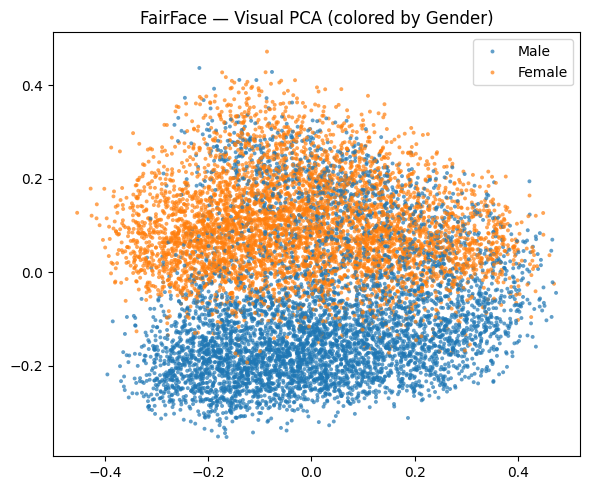

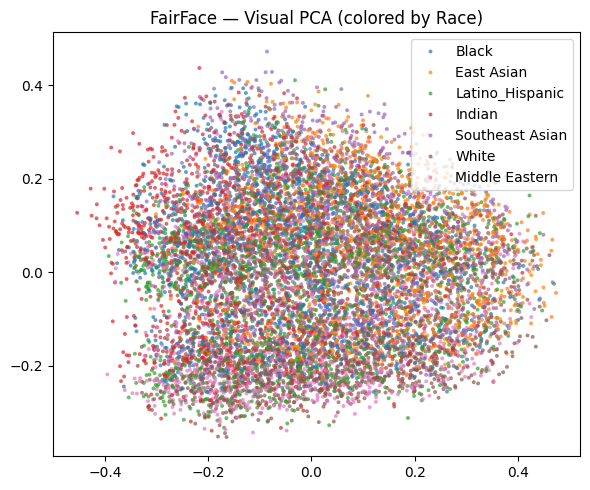

Proj stats (gender): mean=0.0820 std=0.1809
Proj stats (race)  : mean=0.0698 std=0.1770


In [7]:

# %% [markdown]
# PCA: stima direzioni bias (gender, race) e visualizzazione

# %%
# %% [markdown]
# # Step 6 — PCA: direzioni bias e visualizzazione pre-debias

# %%
# Embedding immagine una tantum
Z_img, Genders, Races = encode_images(fairface_loader, model, device)
print("Embeddings FairFace:", Z_img.shape)

# Direzioni bias (k=1 ciascuna)
B_gender = compute_bias_direction(Z_img, Genders, group_a="Male", group_b="Female", k=CONFIG["pca"]["components_per_axis"])
# Per race: prendi le due più frequenti per robustezza
race_counts = pd.Series(Races).value_counts()
if len(race_counts) >= 2:
    ra, rb = race_counts.index[0], race_counts.index[1]
else:
    ra, rb = CONFIG["fairface"]["races"][0], CONFIG["fairface"]["races"][1]
B_race = compute_bias_direction(Z_img, Races, group_a=ra, group_b=rb, k=CONFIG["pca"]["components_per_axis"])

# Plot PCA 2D per diagnostica
plot_pca_scatter(Z_img, Genders, title="FairFace — Visual PCA (colored by Gender)", 
                 outfile=os.path.join(CONFIG["paths"]["outdir"], "pca_gender.png"))
plot_pca_scatter(Z_img, Races, title=f"FairFace — Visual PCA (colored by Race)", 
                 outfile=os.path.join(CONFIG["paths"]["outdir"], "pca_race.png"))

# Magnitudo proiezione lungo direzioni di bias (diagnostica quantitativa)
proj_gender = project_along(Z_img, B_gender).squeeze()  # (N,)
proj_race   = project_along(Z_img, B_race).squeeze()
print("Proj stats (gender): mean=%.4f std=%.4f" % (proj_gender.mean(), proj_gender.std()))
print("Proj stats (race)  : mean=%.4f std=%.4f" % (proj_race.mean(), proj_race.std()))

# %% [markdown]
# Zero-shot su Oxford-IIIT Pets (Top-1, Top-5, Confusion)


In [8]:

# %%
# %% [markdown]
# # Step 7 — Zero-shot: Oxford-IIIT Pets (Top-1, Top-5, Confusion Matrix)

# %%
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

# Oxford-IIIT Pets (test split)
pets_transform = preprocess  # usa la stessa pipeline di CLIP
pets_test = torchvision.datasets.OxfordIIITPet(
    root=CONFIG["pets"]["pets_root"], split="test", target_types="category", download=True, transform=pets_transform
)
pets_loader = DataLoader(
    pets_test, batch_size=CONFIG["pets"]["batch_size"],
    shuffle=False, num_workers=CONFIG["pets"]["num_workers"], pin_memory=(device.type!="cpu")
)

# class names e prompt zero-shot per PETS
idx_to_class = {i:c for i,c in enumerate(pets_test.classes)}
class_prompts = [f"a photo of a {cls.replace('_', ' ')}" for cls in pets_test.classes]
text_emb_pets = encode_text(class_prompts, model, tokenizer, device)
text_emb_pets_t = torch.from_numpy(text_emb_pets).float()  # (C, d)

@torch.no_grad()
def evaluate_zeroshot_pets(model, loader, text_emb, device, use_amp=True):
    model.eval()
    all_preds_top1, all_labels, all_preds_topk = [], [], []
    dtype = torch.float16 if device.type in ("cuda","mps") else torch.float32
    scaler = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else torch.autocast

    Zt = text_emb.to(device)  # (C,d)
    for xb, yb in loader:
        xb = xb.to(device, dtype=dtype, non_blocking=True)
        with scaler(device.type):
            zi = model.encode_image(xb)       # (B,d)
            zi = F.normalize(zi.float(), dim=-1)
        sims = zi @ Zt.T                      # (B, C)

        # top-k
        top5 = torch.topk(sims, k=min(5, Zt.shape[0]), dim=1).indices  # (B,5)
        top1 = top5[:,0]
        all_preds_top1 += top1.cpu().tolist()
        all_preds_topk += [row.cpu().tolist() for row in top5]
        all_labels += yb.tolist()

    # metriche
    top1_acc = accuracy_score(all_labels, all_preds_top1)
    # top-5 acc
    correct_top5 = 0
    for y, topk in zip(all_labels, all_preds_topk):
        if y in topk: correct_top5 += 1
    top5_acc = correct_top5 / len(all_labels)

    # confusion matrix (top-1)
    cm = confusion_matrix(all_labels, all_preds_top1, labels=list(range(len(idx_to_class))))
    return top1_acc, top5_acc, cm, all_labels, all_preds_top1

text_emb_pets_tt = text_emb_pets_t  # CPU tensor
top1, top5, cm, y_true, y_pred = evaluate_zeroshot_pets(model, pets_loader, text_emb_pets_tt, device)
print(f"Oxford-IIIT Pets — Zero-shot: Top-1={top1:.4f}  Top-5={top5:.4f}")


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/timm/models

Oxford-IIIT Pets — Zero-shot: Top-1=0.8441  Top-5=0.9738


SALVARE

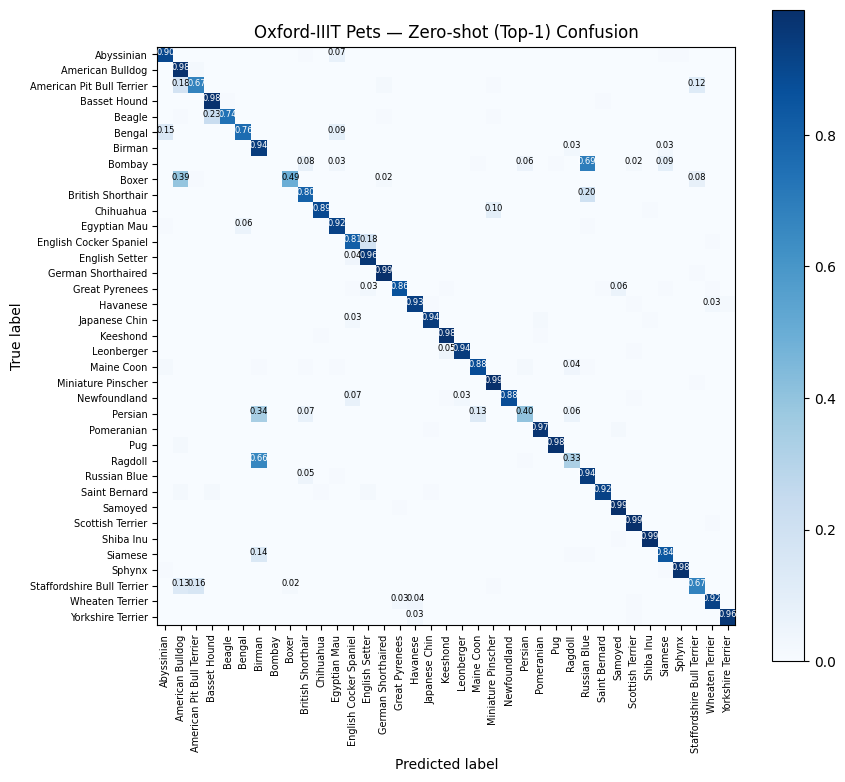

=== Bias — professioni con MINOR gender gap (top 10) ===


,gender_gap,race_gap
nurse,0.028906,0.031123
pilot,0.028906,0.031123
designer,0.028906,0.031123
farmer,0.028906,0.031123
journalist,0.028906,0.031123
banker,0.028906,0.031123
soldier,0.028906,0.031123
artist,0.028906,0.031123
mechanic,0.028906,0.031123
lawyer,0.028906,0.031123


=== Bias — professioni con MAGGIOR gender gap (top 10) ===


,gender_gap,race_gap
driver,0.028906,0.031123
janitor,0.028906,0.031123
police officer,0.028906,0.031123
teacher,0.028906,0.031123
surgeon,0.028906,0.031123
model,0.028906,0.031123
CEO,0.028906,0.031123
software engineer,0.028906,0.031123
chef,0.028906,0.031123
coach,0.028906,0.031123


=== Bias — professioni con MINOR race gap (top 10) ===


,gender_gap,race_gap
nurse,0.028906,0.031123
pilot,0.028906,0.031123
designer,0.028906,0.031123
farmer,0.028906,0.031123
journalist,0.028906,0.031123
banker,0.028906,0.031123
soldier,0.028906,0.031123
artist,0.028906,0.031123
mechanic,0.028906,0.031123
lawyer,0.028906,0.031123


=== Bias — professioni con MAGGIOR race gap (top 10) ===


,gender_gap,race_gap
driver,0.028906,0.031123
janitor,0.028906,0.031123
police officer,0.028906,0.031123
teacher,0.028906,0.031123
surgeon,0.028906,0.031123
model,0.028906,0.031123
CEO,0.028906,0.031123
software engineer,0.028906,0.031123
chef,0.028906,0.031123
coach,0.028906,0.031123



Output salvati in: /Users/andreabaldi/Desktop/AIRO/Computer_Vision/project/final/outputs_baseline


In [9]:

# Plot confusion matrix (salvataggio)
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='Blues', outfile=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)
    plt.figure(figsize=(9,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
    plt.yticks(tick_marks, classes, fontsize=7)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > 0.02:  # evita sovraccarico
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=6)
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    if outfile: plt.savefig(outfile, dpi=140)
    plt.show()

plot_confusion_matrix(cm, [idx_to_class[i] for i in range(len(idx_to_class))],
                      normalize=True,
                      title="Oxford-IIIT Pets — Zero-shot (Top-1) Confusion",
                      outfile=os.path.join(CONFIG["paths"]["outdir"], "pets_confusion.png"))

# %% [markdown]
# Mini-report baseline + salvataggi

# %%
# %% [markdown]
# # Step 8 — Mini-report Baseline: numeri chiave e salvataggi

# %%
# Tabella similarity gap (prime 10 professioni con meno/ più gap)
df_gap = pd.DataFrame(sim_gaps).T
df_gap_sorted_gender = df_gap.sort_values("gender_gap")
df_gap_sorted_race = df_gap.sort_values("race_gap")

print("=== Bias — professioni con MINOR gender gap (top 10) ===")
display(df_gap_sorted_gender.head(10))
print("=== Bias — professioni con MAGGIOR gender gap (top 10) ===")
display(df_gap_sorted_gender.tail(10))

print("=== Bias — professioni con MINOR race gap (top 10) ===")
display(df_gap_sorted_race.head(10))
print("=== Bias — professioni con MAGGIOR race gap (top 10) ===")
display(df_gap_sorted_race.tail(10))

# Salva CSV
df_gap.to_csv(os.path.join(CONFIG["paths"]["outdir"], "similarity_gaps_baseline.csv"))

# Salva proiezioni PCA (statistiche)
with open(os.path.join(CONFIG["paths"]["outdir"], "pca_proj_stats.json"), "w") as f:
    json.dump({
        "gender_proj_mean": float(proj_gender.mean()),
        "gender_proj_std": float(proj_gender.std()),
        "race_proj_mean": float(proj_race.mean()),
        "race_proj_std": float(proj_race.std()),
    }, f, indent=2)

# Salva risultati Pets
with open(os.path.join(CONFIG["paths"]["outdir"], "pets_zeroshot_metrics.json"), "w") as f:
    json.dump({"top1": float(top1), "top5": float(top5)}, f, indent=2)

print("\nOutput salvati in:", os.path.abspath(CONFIG['paths']['outdir']))

# %% [markdown]
# ---------------------------------------DEBIASED_MODEL----------------------------------------------

# %% [markdown]
# ____________________________________________________________________________________________

# %% [markdown]
# CLAUDE


TRAINING 

In [10]:

# %%
#============== SETUP TRAIN/VAL DATASETS (improved) ==============
import pandas as pd
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import torch.nn.functional as F
import numpy as np
import random
import open_clip
import torch.nn as nn

# ------------------ CSV quick diagnostics ------------------
df_train = pd.read_csv(CONFIG["paths"]["fairface_csv"])
df_val   = pd.read_csv(CONFIG["paths"]["fairface_csv_val"])

print(f"Raw CSV train: {len(df_train)} rows")
print(f"Raw CSV val:   {len(df_val)} rows")
print(f"Train columns:  {df_train.columns.tolist()}")
print(f"Train genders:  {df_train['gender'].unique()}")
print(f"Train races:    {df_train['race'].unique()}")

# ------------------ Dataset with robust paths + group weights ------------------
class FairFaceDatasetFixed(Dataset):
    """
    FairFace dataset with robust path handling and per-sample group weights
    for balanced sampling by (gender, race).
    """
    def __init__(
        self, root: str, csv_path: str, transform, genders, races,
        exclude_unknown: bool = True, max_per_group: int | None = None
    ):
        super().__init__()
        self.root = root
        self.df = pd.read_csv(csv_path).copy()
        self.transform = transform
        self.genders = list(genders)
        self.races = list(races)

        print(f"  Raw CSV rows: {len(self.df)}")

        if exclude_unknown:
            before = len(self.df)
            self.df = self.df[
                (self.df["gender"].isin(self.genders)) &
                (self.df["race"].isin(self.races))
            ].reset_index(drop=True)
            print(f"  After filtering gender/race: {len(self.df)} (removed {before - len(self.df)})")

        # Optional capping per (gender,race) group (train usually NO cap)
        if max_per_group is not None:
            rows = []
            for g in sorted(set(self.genders)):
                for r in sorted(set(self.races)):
                    sub = self.df[(self.df.gender == g) & (self.df.race == r)]
                    if len(sub) > max_per_group:
                        sub = sub.sample(max_per_group, random_state=42)
                    rows.append(sub)
            self.df = pd.concat(rows, ignore_index=True)
            print(f"  After max_per_group balancing: {len(self.df)}")

        # Normalize/build absolute paths
        paths, missing = [], 0
        for fp in self.df["file"].astype(str).tolist():
            norm_p = fp.lstrip("./")
            if norm_p.startswith("train/") or norm_p.startswith("val/"):
                norm_p = os.path.basename(norm_p)
            full_path = os.path.join(self.root, norm_p)
            if not os.path.exists(full_path):
                missing += 1
                paths.append(None)
            else:
                paths.append(full_path)
        valid_idx = [i for i, p in enumerate(paths) if p is not None]
        self.df = self.df.iloc[valid_idx].reset_index(drop=True)
        self.paths = [paths[i] for i in valid_idx]
        print(f"  After removing missing files: {len(self.df)} (missing: {missing})")

        self.genders_list = self.df["gender"].tolist()
        self.races_list   = self.df["race"].tolist()

        # ----- Group weights for a WeightedRandomSampler (balance by (gender,race)) -----
        grp = list(zip(self.genders_list, self.races_list))
        from collections import Counter
        counts = Counter(grp)
        self.sample_weights = torch.tensor([1.0 / counts[(g, r)] for g, r in grp], dtype=torch.float)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert("RGB")
            x = self.transform(img)
            return x, self.genders_list[idx], self.races_list[idx]
        except Exception as e:
            print(f"Error loading {self.paths[idx]}: {e}")
            return None


Raw CSV train: 86744 rows
Raw CSV val:   10954 rows
Train columns:  ['file', 'age', 'gender', 'race', 'service_test']
Train genders:  ['Male' 'Female']
Train races:    ['East Asian' 'Indian' 'Black' 'White' 'Middle Eastern' 'Latino_Hispanic'
 'Southeast Asian']


BLENDED LOADER

In [11]:

# === COCO ADDITION START: DATASET CSV-BASED ===
import pandas as pd
from PIL import Image
import re
from collections import defaultdict

class CocoPersonDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, max_images=None, person_only=True):
        # Legge CSV senza intestazione
        self.data = pd.read_csv(csv_path, header=None, names=["file", "caption"])

        if person_only:
            self.data = self.data[self.data['caption'].str.contains('person|man|woman', case=False, na=False)]

        if max_images:
            self.data = self.data.head(max_images)

        # ✅ FIX fondamentale: resetta indici
        self.data = self.data.reset_index(drop=True)

        # Estrai il contesto
        import re
        self.data["context"] = self.data["caption"].astype(str).apply(
            lambda t: re.search(r"\b(\w+ing)\b", t).group(1) if re.search(r"\b(\w+ing)\b", t) else "generic"
        )

        self.img_dir = img_dir
        self.transform = transform
        print(f"✓ COCO CSV subset ready: {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, str(row['file']))
        img = Image.open(img_path).convert('RGB')
        caption = str(row['caption']).lower()

        gender = "Male" if "man" in caption or "boy" in caption else (
            "Female" if "woman" in caption or "girl" in caption else random.choice(["Male", "Female"])
        )
        race = random.choice(CONFIG["fairface"]["races"])

        if self.transform:
            img = self.transform(img)
        return img, gender, race, row["context"]

class ContextBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size):
        self.context_to_indices = defaultdict(list)
        for idx, row in dataset.data.iterrows():
            self.context_to_indices[row["context"]].append(idx)
        self.contexts = list(self.context_to_indices.keys())
        self.batch_size = batch_size

    def __iter__(self):
        contexts = np.random.permutation(self.contexts)
        for ctx in contexts:
            ids = self.context_to_indices[ctx]
            random.shuffle(ids)
            for i in range(0, len(ids), self.batch_size):
                yield ids[i:i+self.batch_size]

    def __len__(self):
        return sum(len(v)//self.batch_size for v in self.context_to_indices.values())

coco_train_ds = CocoPersonDataset(
    csv_path=CONFIG["paths"]["coco_ann_train"],
    img_dir=CONFIG["coco"]["train_dir"],
    transform=preprocess,
    max_images=CONFIG["coco"]["max_images"]
)
coco_train_loader = DataLoader(
    coco_train_ds,
    batch_sampler=ContextBatchSampler(coco_train_ds, CONFIG["coco"]["batch_size"]),
    num_workers=CONFIG["coco"]["num_workers"],
    pin_memory=(device.type != "cpu")
)
# === COCO ADDITION END: DATASET CSV-BASED ===

# ------------------ Instantiate train/val datasets ------------------
print("\n=== Loading Train Dataset ===")
fairface_train_ds = FairFaceDatasetFixed(
    root=CONFIG["paths"]["fairface_root"],
    csv_path=CONFIG["paths"]["fairface_csv"],
    transform=preprocess,
    genders=CONFIG["fairface"]["genders"],
    races=CONFIG["fairface"]["races"],
    exclude_unknown=True,
    max_per_group=None
)

print("\n=== Loading Val Dataset ===")
fairface_val_ds = FairFaceDatasetFixed(
    root=CONFIG["paths"]["fairface_val_root"],
    csv_path=CONFIG["paths"]["fairface_csv_val"],
    transform=preprocess,
    genders=CONFIG["fairface"]["genders"],
    races=CONFIG["fairface"]["races"],
    exclude_unknown=True,
    max_per_group=None
)

# ------------------ Collate that skips None ------------------
def collate_fn_skip_none(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

# ------------------ Balanced sampler (train) ------------------
train_sampler = WeightedRandomSampler(
    weights=fairface_train_ds.sample_weights,
    num_samples=len(fairface_train_ds),
    replacement=True
)

fairface_train_loader = DataLoader(
    fairface_train_ds,
    batch_size=16,
    sampler=train_sampler,          # balanced by (gender,race)
    shuffle=False,                  # sampler controls the order
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn_skip_none
)

fairface_val_loader = DataLoader(
    fairface_val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn_skip_none
)

print(f"\n✓ Train dataset: {len(fairface_train_ds)} images")
print(f"✓ Val dataset:   {len(fairface_val_ds)} images")

# === COCO ADDITION START: BLENDED LOADER ===
# === FIXED BLENDED LOADER ===
# === FIXED BLENDED LOADER (ROBUST) ===
def blended_loader(loader_a, loader_b, ratio_a=0.7, ratio_b=0.3):
    """
    Itera batch da due DataLoader diversi mantenendo proporzioni stimate,
    evitando errori di StopIteration o index out of bounds.
    """
    iter_a, iter_b = iter(loader_a), iter(loader_b)
    exhausted_a = exhausted_b = False

    while True:
        # Se entrambi esauriti → fine loop
        if exhausted_a and exhausted_b:
            break

        pick_a = random.random() < ratio_a

        # Se scegliamo A ma è esaurito, prova B
        if pick_a and not exhausted_a:
            try:
                yield next(iter_a)
                continue
            except StopIteration:
                exhausted_a = True

        # Se scegliamo B ma è esaurito, prova A
        if not pick_a and not exhausted_b:
            try:
                yield next(iter_b)
                continue
            except StopIteration:
                exhausted_b = True

        # Se uno dei due è rimasto, esaurisci quello
        if not exhausted_a:
            try:
                yield next(iter_a)
                continue
            except StopIteration:
                exhausted_a = True
        if not exhausted_b:
            try:
                yield next(iter_b)
                continue
            except StopIteration:
                exhausted_b = True# === COCO ADDITION END: BLENDED LOADER ===


✓ COCO CSV subset ready: 8164 samples

=== Loading Train Dataset ===
  Raw CSV rows: 86744
  After filtering gender/race: 86744 (removed 0)
  After removing missing files: 86744 (missing: 0)

=== Loading Val Dataset ===
  Raw CSV rows: 10954
  After filtering gender/race: 10954 (removed 0)
  After removing missing files: 10954 (missing: 0)

✓ Train dataset: 86744 images
✓ Val dataset:   10954 images


In [12]:

#============== SETUP TEACHER MODEL ==============
print("\n=== Setting up Teacher Model ===")
teacher_model, _, _ = open_clip.create_model_and_transforms(
    CONFIG["clip"]["variant"],
    pretrained=CONFIG["clip"]["pretrained"],
    device=device
)
teacher_model.eval()
for p in teacher_model.parameters():
    p.requires_grad = False
print("✓ Teacher model loaded and frozen")



=== Setting up Teacher Model ===
✓ Teacher model loaded and frozen


In [ ]:

from tqdm import tqdm
#============== SETUP LORA (kept conservative) ==============
from peft import get_peft_model, LoraConfig
import math, time
from tqdm import tqdm

def approx_epoch_steps():
    # 70% FairFace + 30% COCO (stesso mix del blended loader)
    return int(0.7 * len(fairface_train_loader) + 0.3 * len(coco_train_loader))


print("\n=== Setting up LoRA ===")
try:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["c_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type="FEATURE_EXTRACTION"
    )
    model_lora = get_peft_model(model, lora_config)
except Exception as e:
    print(f"LoRA setup warning: {e}\nFalling back to base model (no LoRA).")
    model_lora = model

model_lora.print_trainable_parameters()
model_lora.train()

#============== LOSS DEFINITIONS (fixed CLIP loss for multi-prompts) ==============
def compute_bias_direction_from_embeddings(Z: np.ndarray, groups: np.ndarray,
                                           group_a: str, group_b: str, k: int = 1):
    from sklearn.decomposition import PCA
    Za = Z[groups == group_a]
    Zb = Z[groups == group_b]
    if len(Za) < 2 or len(Zb) < 2:
        print(f"Warning: insufficient samples for {group_a} vs {group_b}")
        return np.random.randn(k, Z.shape[1]).astype(np.float32)
    n = min(len(Za), len(Zb), 1000)
    rng = np.random.default_rng(42)
    Za = Za[rng.choice(len(Za), size=n, replace=False)]
    Zb = Zb[rng.choice(len(Zb), size=n, replace=False)]
    D = Za - Zb
    pca = PCA(n_components=k, random_state=42).fit(D)
    return pca.components_.astype(np.float32)

class BiasReductionLoss(nn.Module):
    def __init__(self, bias_directions_gender, bias_directions_race):
        super().__init__()
        self.register_buffer("B_gender", torch.from_numpy(bias_directions_gender).float())
        self.register_buffer("B_race",   torch.from_numpy(bias_directions_race).float())
    def forward(self, image_embeddings):
        proj_gender = image_embeddings @ self.B_gender.T
        proj_race   = image_embeddings @ self.B_race.T
        loss_gender = (proj_gender.abs().mean() + (proj_gender ** 2).mean()) / 0.5
        loss_race   = (proj_race.abs().mean()   + (proj_race   ** 2).mean()) / 0.5
        return loss_gender + loss_race

class BalancedClipBiasLoss(nn.Module):
    def __init__(self, bias_loss_fn: nn.Module):
        super().__init__()
        self.bias_loss_fn = bias_loss_fn
        self.register_buffer("bias_loss_scale", torch.tensor(1.0))
        self.register_buffer("step_count", torch.tensor(0, dtype=torch.long))
    def forward(self, image_emb, text_emb_grouped,
                teacher_image_emb=None, teacher_text_emb_grouped=None,
                kl_weight: float = 0.2):
        B, d = image_emb.shape
        text_emb_avg = text_emb_grouped.mean(dim=1)
        logits = (image_emb @ text_emb_avg.T) / 0.07
        targets = torch.arange(B, device=image_emb.device)
        clip_loss = F.cross_entropy(logits, targets)
        bias_loss = self.bias_loss_fn(image_emb)
        kl_loss = torch.tensor(0.0, device=image_emb.device)
        if (teacher_image_emb is not None) and (teacher_text_emb_grouped is not None):
            teacher_avg = teacher_text_emb_grouped.mean(dim=1)
            t_logits = (teacher_image_emb @ teacher_avg.T) / 0.07
            s_logits = logits
            minB = min(t_logits.shape[1], s_logits.shape[1])
            t_probs = F.softmax(t_logits[:, :minB], dim=1)
            s_logp = F.log_softmax(s_logits[:, :minB], dim=1)
            kl_loss = F.kl_div(s_logp, t_probs, reduction="batchmean")
        with torch.no_grad():
            ratio = clip_loss.detach() / (bias_loss.detach() + 1e-6)
            ratio = torch.clamp(ratio, 1.0, 100.0)
            alpha = 0.99
            self.bias_loss_scale.data = alpha * self.bias_loss_scale + (1 - alpha) * ratio
            self.step_count += 1
        final_scale = torch.clamp(self.bias_loss_scale, 1.0, 50.0)
        weighted_bias_loss = bias_loss * final_scale * 0.5
        total_loss = clip_loss + weighted_bias_loss + kl_weight * kl_loss
        return {
            "loss": total_loss,
            "clip_loss": clip_loss.item(),
            "bias_loss": bias_loss.item(),
            "kl_loss": kl_loss.item() if isinstance(kl_loss, torch.Tensor) else 0.0,
            "bias_scale": self.bias_loss_scale.item()
        }

def get_prompts_for_batch(genders, races, professions_subset, cfg_prompts, num_per_image=2):
    gtok = cfg_prompts["gender_tokens"]
    rtok = cfg_prompts["race_tokens"]
    ts   = cfg_prompts["templates_sensitive"]
    per_image_prompts = []
    for g, r in zip(genders, races):
        prof = random.choice(professions_subset)
        gword, rword = gtok[g], rtok[r]
        K = min(num_per_image, len(ts))
        chosen = random.sample(ts, K)
        per_image_prompts.append([tmpl.format(gender=gword, race=rword, profession=prof) for tmpl in chosen])
    return per_image_prompts

def encode_images_batch(xb, model, device, requires_grad=False):
    xb = xb.to(device, dtype=torch.float32, non_blocking=True)
    if requires_grad:
        z = model.encode_image(xb)
    else:
        with torch.no_grad():
            z = model.encode_image(xb)
    return F.normalize(z, dim=-1)

def encode_text_grouped(per_image_prompts, tokenizer, model, device, requires_grad=False):
    B = len(per_image_prompts)
    if B == 0:
        return torch.empty((0, 0, 512), device=device)
    flat = [p for sub in per_image_prompts for p in sub]
    toks = tokenizer(flat).to(device)
    if requires_grad:
        zt = model.encode_text(toks)
    else:
        with torch.no_grad():
            zt = model.encode_text(toks)
    zt = F.normalize(zt, dim=-1)
    K = len(per_image_prompts[0])
    d = zt.shape[-1]
    return zt.view(B, K, d)

def train_epoch(model, teacher_model, train_loader, loss_fn, optimizer, tokenizer, device, epoch_idx: int, total_epochs: int):
    model.train()
    teacher_model.eval()
    kl_w = 0.4 if epoch_idx < (0.5 * total_epochs) else 0.15

    total_loss = total_clip = total_bias = total_kl = 0.0
    n_batches = 0
    target_steps = approx_epoch_steps()

    autocast_dtype = torch.float16 if device.type in ("mps", "cuda") else torch.float32
    pbar = tqdm(total=target_steps, desc=f"Train Epoch {epoch_idx+1}/{total_epochs}", leave=True)
    steps = 0
    for batch in blended_loader(fairface_train_loader, coco_train_loader):
        if steps >= target_steps:
            break
        if batch is None:
            continue
        xb, genders, races, *_ = batch
        profs_subset = CONFIG["prompts"]["professions"][:20]
        per_img_prompts = get_prompts_for_batch(genders, races, profs_subset, CONFIG["prompts"], num_per_image=2)
        if len(per_img_prompts) == 0:
            continue

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, dtype=autocast_dtype):
            img_stu = encode_images_batch(xb, model, device, requires_grad=True)
            txt_stu = encode_text_grouped(per_img_prompts, tokenizer, model, device, True)
            img_tch = encode_images_batch(xb, teacher_model, device, requires_grad=False)
            txt_tch = encode_text_grouped(per_img_prompts, tokenizer, teacher_model, device)

            loss_dict = loss_fn(
                img_stu, txt_stu,
                teacher_image_emb=img_tch,
                teacher_text_emb_grouped=txt_tch,
                kl_weight=kl_w
            )
            loss = loss_dict["loss"]

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_clip += loss_dict["clip_loss"]
        total_bias += loss_dict["bias_loss"]
        total_kl   += loss_dict["kl_loss"]
        n_batches  += 1
        steps += 1
        pbar.update(1)
    pbar.close()

    if n_batches == 0:
        return None
    return {
        "train_loss": total_loss / n_batches,
        "train_clip_loss": total_clip / n_batches,
        "train_bias_loss": total_bias / n_batches,
        "train_kl_loss": total_kl / n_batches
    }

@torch.no_grad()
def validate_epoch(model, teacher_model, val_loader, loss_fn, tokenizer, device, epoch_idx: int, total_epochs: int):
    model.eval()
    teacher_model.eval()
    kl_w = 0.4 if epoch_idx < (0.5 * total_epochs) else 0.15
    total_loss = total_clip = total_bias = total_kl = 0.0
    n_batches = 0
    autocast_dtype = torch.float16 if device.type in ("mps", "cuda") else torch.float32
    for batch in tqdm(val_loader, desc=f"Valid Epoch {epoch_idx+1}/{total_epochs}", leave=True):
        if batch is None:
            continue
        xb, genders, races, *_ = batch
        profs_subset = CONFIG["prompts"]["professions"][:20]
        per_img_prompts = get_prompts_for_batch(genders, races, profs_subset, CONFIG["prompts"], num_per_image=2)
        if len(per_img_prompts) == 0:
            continue
        with torch.autocast(device_type=device.type, dtype=autocast_dtype):
            img_stu = encode_images_batch(xb, model, device, requires_grad=False)
            txt_stu = encode_text_grouped(per_img_prompts, tokenizer, model, device, False)
            img_tch = encode_images_batch(xb, teacher_model, device, requires_grad=False)
            txt_tch = encode_text_grouped(per_img_prompts, tokenizer, teacher_model, device, False)
            loss_dict = loss_fn(
                img_stu, txt_stu,
                teacher_image_emb=img_tch,
                teacher_text_emb_grouped=txt_tch,
                kl_weight=kl_w
            )
            total_loss += loss_dict["loss"].item()
            total_clip += loss_dict["clip_loss"]
            total_bias += loss_dict["bias_loss"]
            total_kl   += loss_dict["kl_loss"]
            n_batches  += 1
    if n_batches == 0:
        return None
    return {
        "val_loss": total_loss / n_batches,
        "val_clip_loss": total_clip / n_batches,
        "val_bias_loss": total_bias / n_batches,
        "val_kl_loss": total_kl / n_batches
    }

print("\n" + "="*70)
print("COMPUTING INITIAL BIAS DIRECTIONS")
print("="*70)
sample_size = min(5000, len(fairface_train_ds))
indices = np.random.choice(len(fairface_train_ds), size=sample_size, replace=False)
subset_ds = torch.utils.data.Subset(fairface_train_ds, indices)
subset_loader = DataLoader(subset_ds, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_none)
Z_samples, G_samples, R_samples = [], [], []
for batch in subset_loader:
    if batch is None: 
        continue
    xb, genders, races, *_ = batch
    with torch.no_grad():
        z = model.encode_image(xb.to(device))
        z = F.normalize(z, dim=-1)
    Z_samples.append(z.cpu().numpy())
    G_samples.extend(list(genders))
    R_samples.extend(list(races))
Z_all = np.concatenate(Z_samples, axis=0)
G_all = np.array(G_samples)
R_all = np.array(R_samples)
print(f"Sampled {len(Z_all)} embeddings for bias direction computation")
B_gender = compute_bias_direction_from_embeddings(Z_all, G_all, "Male", "Female", k=1)
race_counts = pd.Series(R_all).value_counts()
if len(race_counts) >= 2:
    ra, rb = race_counts.index[0], race_counts.index[1]
else:
    ra, rb = CONFIG["fairface"]["races"][0], CONFIG["fairface"]["races"][1]
B_race = compute_bias_direction_from_embeddings(Z_all, R_all, ra, rb, k=1)
print(f"✓ Bias direction (gender): {B_gender.shape}")
print(f"✓ Bias direction (race, {ra} vs {rb}): {B_race.shape}")
bias_loss_fn = BiasReductionLoss(B_gender, B_race).to(device)
combined_loss_fn = BalancedClipBiasLoss(bias_loss_fn)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_lora.parameters()),
    lr=1e-4, weight_decay=0.01
)
n_epochs = 3
best_val_bias_loss, best_epoch = float("inf"), 0
history = {"train_loss": [], "val_loss": [], "train_bias": [], "val_bias": []}
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)
CONFIG["prompts"]["professions"] += [
    "surfer", "skateboarder", "snowboarder", "person riding a horse",
    "person eating a sandwich", "person flying a kite", "person holding a donut"
]
for epoch in range(n_epochs):
    print(f"\n{'='*70}\nEpoch {epoch+1}/{n_epochs}\n{'='*70}")
    blended_iter = blended_loader(fairface_train_loader, coco_train_loader)
    train_metrics = train_epoch(model_lora, teacher_model, blended_iter,
                                combined_loss_fn, optimizer, tokenizer, device, epoch, n_epochs)
    if train_metrics is None:
        print("⚠ Training epoch failed (no valid batches)"); 
        continue
    val_metrics = validate_epoch(model_lora, teacher_model, fairface_val_loader,
                                 combined_loss_fn, tokenizer, device, epoch, n_epochs)
    if val_metrics is None:
        print("⚠ Validation epoch failed (no valid batches)"); 
        continue
    print(f"\nTrain Loss: {train_metrics['train_loss']:.6f}")
    print(f"  ├─ CLIP: {train_metrics['train_clip_loss']:.6f}")
    print(f"  ├─ Bias: {train_metrics['train_bias_loss']:.6f}")
    print(f"  └─ KL:   {train_metrics['train_kl_loss']:.6f}")
    print(f"Val Loss:   {val_metrics['val_loss']:.6f}")
    print(f"  ├─ CLIP: {val_metrics['val_clip_loss']:.6f}")
    print(f"  ├─ Bias: {val_metrics['val_bias_loss']:.6f}")
    print(f"  └─ KL:   {val_metrics['val_kl_loss']:.6f}")
    if val_metrics["val_bias_loss"] < best_val_bias_loss:
        best_val_bias_loss, best_epoch = val_metrics["val_bias_loss"], epoch
        best_path = os.path.join(CONFIG["paths"]["outdir"], f"best_model_lora_epoch{epoch+1}.pt")
        torch.save(model_lora.state_dict(), best_path)
        print(f"✓ New best model saved (epoch {epoch+1}, bias_loss={best_val_bias_loss:.6f})")
    torch.save(model_lora.state_dict(), os.path.join(CONFIG["paths"]["outdir"], f"checkpoint_epoch{epoch+1}.pt"))
    history["train_loss"].append(train_metrics["train_loss"])
    history["val_loss"].append(val_metrics["val_loss"])
    history["train_bias"].append(train_metrics["train_bias_loss"])
    history["val_bias"].append(val_metrics["val_bias_loss"])
with open(os.path.join(CONFIG["paths"]["outdir"], "training_history.json"), "w") as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f, indent=2)
print(f"\n{'='*70}")
print(f"✓ Training complete. Best epoch: {best_epoch+1}")
print(f"✓ Best val bias loss: {best_val_bias_loss:.6f}")
print(f"✓ Models saved to {CONFIG['paths']['outdir']}")
print(f"{'='*70}")



=== Setting up LoRA ===
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 614,400 || all params: 151,891,713 || trainable%: 0.4044986970421487

COMPUTING INITIAL BIAS DIRECTIONS


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


Sampled 5000 embeddings for bias direction computation
✓ Bias direction (gender): (1, 512)
✓ Bias direction (race, White vs Latino_Hispanic): (1, 512)

STARTING TRAINING

Epoch 1/3


Train Epoch 1/3:   0%|          | 0/3928 [00:00<?, ?it/s]/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Valid Epoch 1/3: 100%|██████████| 685/685 [03:47<00:00,  3.01it/s]



Train Loss: 2.144479
  ├─ CLIP: 1.728727
  ├─ Bias: 0.020123
  └─ KL:   0.285398
Val Loss:   1.893853
  ├─ CLIP: 1.604673
  ├─ Bias: 0.005373
  └─ KL:   0.387120
✓ New best model saved (epoch 1, bias_loss=0.005373)

Epoch 2/3


Valid Epoch 2/3: 100%|██████████| 685/685 [03:44<00:00,  3.05it/s]



Train Loss: 1.954768
  ├─ CLIP: 1.630990
  ├─ Bias: 0.007049
  └─ KL:   0.368893
Val Loss:   1.858988
  ├─ CLIP: 1.522674
  ├─ Bias: 0.005383
  └─ KL:   0.504360

Epoch 3/3


Valid Epoch 3/3: 100%|██████████| 685/685 [03:41<00:00,  3.10it/s]



Train Loss: 1.752719
  ├─ CLIP: 1.497329
  ├─ Bias: 0.006052
  └─ KL:   0.693903
Val Loss:   1.756458
  ├─ CLIP: 1.378937
  ├─ Bias: 0.009473
  └─ KL:   0.937984

✓ Training complete. Best epoch: 1
✓ Best val bias loss: 0.005373
✓ Models saved to ./outputs_baseline
✓ Loaded best LoRA weights from best_model_lora_epoch1.pt

=== Evaluating Bias on FairFace and COCO ===


ValueError: too many values to unpack (expected 3)

In [25]:
import os, torch, pandas as pd
import torch.nn.functional as F
from itertools import islice

# === DEVICE SETUP ===
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")

# === RELOAD MODEL WITH LORA ===
from peft import get_peft_model, LoraConfig

print("\n=== Reloading base CLIP + LoRA ===")
base_model = model  # CLIP vanilla già caricato
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)
model_lora = get_peft_model(base_model, lora_config).to(device)
model_lora.eval()

# === LOAD BEST WEIGHTS ===
best_path = max(
    [f for f in os.listdir(CONFIG["paths"]["outdir"]) if f.startswith("best_model_lora")],
    key=lambda f: os.path.getmtime(os.path.join(CONFIG["paths"]["outdir"], f))
)
model_lora.load_state_dict(torch.load(os.path.join(CONFIG["paths"]["outdir"], best_path), map_location=device))
print(f"✓ Loaded best LoRA weights from {best_path}")

# === UTILITY FUNCTIONS ===
def encode_images_batch(xb, model, device, requires_grad=False):
    xb = xb.to(device, dtype=torch.float32, non_blocking=True)
    if requires_grad:
        z = model.encode_image(xb)
    else:
        with torch.no_grad():
            z = model.encode_image(xb)
    return F.normalize(z, dim=-1)

def encode_texts(prompts, tokenizer, model, device):
    toks = tokenizer(prompts).to(device)
    with torch.no_grad():
        zt = model.encode_text(toks)
        zt = F.normalize(zt, dim=-1)
    return zt

@torch.no_grad()
def compute_similarity_gap_by_profession(model, tokenizer, device, loader, cfg_prompts, genders, races, professions_subset):
    results = {}
    model.eval()
    for profession in professions_subset:
        print(f"Evaluating {profession}...")
        sims = {g: [] for g in genders}
        for batch in loader:
            xb, gb, rb, *_ = batch
            xb = xb.to(device)
            img_emb = encode_images_batch(xb, model, device)
            for g in genders:
                for r in races:
                    prompt = f"a photo of a {g.lower()} {r.lower()} person {profession}"
                    text_emb = encode_texts([prompt], tokenizer, model, device)
                    sim = (img_emb @ text_emb.T).mean().item()
                    sims[g].append(sim)
        avg_sims = {g: sum(v)/len(v) for g, v in sims.items() if len(v) > 0}
        if len(avg_sims) >= 2:
            diff = abs(avg_sims[genders[0]] - avg_sims[genders[1]])
        else:
            diff = 0.0
        results[profession] = diff
    return results

# === LIMIT EVALUATION SIZE FOR SPEED ===
profs_eval = CONFIG["prompts"]["professions"][:10]  # ridotto a 10 professioni
races_eval = CONFIG["fairface"]["races"][:3]        # 3 razze principali (es. White, Black, Asian)

def limited_loader(loader, max_batches=250):
    for i, batch in enumerate(loader):
        if i >= max_batches:
            break
        yield batch

# === RUN EVALUATION (FASTER) ===
print("\n=== Evaluating Bias on FairFace and COCO (subset) ===")
sim_gap_ff = compute_similarity_gap_by_profession(
    model_lora, tokenizer, device,
    limited_loader(fairface_val_loader, max_batches=250),
    CONFIG["prompts"],
    CONFIG["fairface"]["genders"],
    races_eval,
    professions_subset=profs_eval
)
sim_gap_coco = compute_similarity_gap_by_profession(
    model_lora, tokenizer, device,
    limited_loader(coco_train_loader, max_batches=250),
    CONFIG["prompts"],
    CONFIG["fairface"]["genders"],
    races_eval,
    professions_subset=profs_eval
)

# === SAVE RESULTS ===
outdir = CONFIG["paths"]["outdir"]
pd.DataFrame(sim_gap_ff, index=["gap"]).T.to_csv(os.path.join(outdir, "similarity_gaps_fairface.csv"))
pd.DataFrame(sim_gap_coco, index=["gap"]).T.to_csv(os.path.join(outdir, "similarity_gaps_coco.csv"))
print("✓ Bias evaluation (subset) completed and saved.")

✓ Using device: mps

=== Reloading base CLIP + LoRA ===
✓ Loaded best LoRA weights from best_model_lora_epoch1.pt

=== Evaluating Bias on FairFace and COCO (subset) ===
Evaluating nurse...
Evaluating software engineer...
Evaluating CEO...
Evaluating model...
Evaluating surgeon...
Evaluating teacher...
Evaluating police officer...
Evaluating janitor...
Evaluating driver...
Evaluating scientist...
Evaluating nurse...
Evaluating software engineer...
Evaluating CEO...
Evaluating model...
Evaluating surgeon...
Evaluating teacher...
Evaluating police officer...
Evaluating janitor...
Evaluating driver...
Evaluating scientist...
✓ Bias evaluation (subset) completed and saved.


ANALISI COCO + POST FINE TUNING EVALUATION 

In [39]:
# ===================== ANALYSIS TOOLKIT (COCO & FAIRFACE) =====================
import os, json, math, random, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Assunzioni minime disponibili in memoria ---
# CONFIG, tokenizer, coco_train_loader, fairface_val_loader
# model_lora (finetuned) potrà essere ricaricato; teacher_model opzionale.
device = torch.device("mps" if torch.backends.mps.is_available()
                      else ("cuda" if torch.cuda.is_available() else "cpu"))
OUTDIR = CONFIG["paths"]["outdir"]
os.makedirs(OUTDIR, exist_ok=True)

# Se il teacher non è definito, prova a usare `model` (base CLIP) come fallback
try:
    _ = teacher_model
except NameError:
    teacher_model = model  # fallback sicuro se il teacher è ancora in memoria

# ===================== Helpers comuni =====================

@torch.no_grad()
def encode_texts(prompts, tokenizer, model):
    toks = tokenizer(prompts).to(device)
    zt = model.encode_text(toks)
    return F.normalize(zt, dim=-1)

def subsample_loader(loader, max_batches=None):
    if max_batches is None:
        for b in loader: yield b
    else:
        for i, b in enumerate(loader):
            if i >= max_batches: break
            yield b

def pca_2d(X, n_components=2):
    Xc = X - X.mean(0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = Xc @ Vt[:n_components].T
    explained = (S[:n_components]**2) / (S**2).sum()
    return Z, explained

def scatter_pca(Z, labels, title, save_path):
    plt.figure(figsize=(6,5))
    # Z: (N,2), labels: list di stringhe
    classes = sorted(set(labels))
    for cls in classes:
        idx = [i for i,l in enumerate(labels) if l==cls]
        arr = np.array([Z[i] for i in idx])
        if len(arr)>0:
            plt.scatter(arr[:,0], arr[:,1], s=8, label=str(cls), alpha=0.7)
    plt.legend(loc="best")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# ===================== 1) Bias CLIP su COCO + PCA =====================
def bias_detection_clip_on_coco(model_clip, tokenizer, coco_loader,
                                genders, races, professions_subset,
                                max_batches=100):
    """
    - Estrae embedding immagine su COCO (subset veloce).
    - Costruisce prompt sensibili (genere/razza/profession) e calcola gap.
    - Esegue PCA 2D sulle embedding immagine per visualizzare separazione tra gruppi.
    """
    model_clip.eval()

    img_embs, gen_labels, race_labels = [], [], []
    for batch in subsample_loader(coco_loader, max_batches=max_batches):
        if batch is None: continue
        xb, genders_b, races_b, *_ = batch
        ze = encode_images_batch(xb, model_clip, device)  # (B,d)
        img_embs.append(ze.cpu().numpy())
        gen_labels += list(genders_b)
        race_labels += list(races_b)
    if len(img_embs)==0:
        raise RuntimeError("COCO loader empty in analysis.")
    X = np.concatenate(img_embs, axis=0)

    # PCA per genere
    Zg, eg = pca_2d(X, n_components=2)
    scatter_pca(Zg, gen_labels,
                title="CLIP base – PCA on COCO (colored by Gender)",
                save_path=os.path.join(OUTDIR, "pca_coco_clip_gender.png"))
    # PCA per razza
    Zr, er = pca_2d(X, n_components=2)
    scatter_pca(Zr, race_labels,
                title="CLIP base – PCA on COCO (colored by Race)",
                save_path=os.path.join(OUTDIR, "pca_coco_clip_race.png"))

    # Similarity gaps per profession (gender gap)
    gaps = {}
    for prof in professions_subset:
        # Costruiamo 2 prompt per genere e mediamo su razze per robustezza
        sims_gender = {g: [] for g in genders}
        for g in genders:
            for r in races:
                prompt = f"a photo of a {g.lower()} {r.lower()} person {prof}"
                zt = encode_texts([prompt], tokenizer, model_clip)  # (1,d)
                sim = (torch.from_numpy(X).to(device) @ zt.T).squeeze(-1)  # (N,)
                sims_gender[g].append(sim.mean().item())
        # media tra le razze
        avg_g = {g: (sum(sims_gender[g]) / max(1,len(sims_gender[g]))) for g in genders}
        if len(genders) >= 2:
            gap = abs(avg_g[genders[0]] - avg_g[genders[1]])
        else:
            gap = 0.0
        gaps[prof] = gap

    # Salvataggi principali
    out = {
        "explained_var_gender": eg.tolist(),
        "explained_var_race": er.tolist(),
        "gender_gap_by_profession": gaps
    } 
    with open(os.path.join(OUTDIR, "bias_metrics_clip_coco.json"), "w") as f:
        json.dump(out, f, indent=2)
    pd.DataFrame(gaps, index=["gap"]).T.sort_values("gap", ascending=False)\
      .to_csv(os.path.join(OUTDIR, "bias_gaps_clip_coco.csv"))
    print("✓ Bias CLIP on COCO computed. PCA figures & CSV saved.")


In [40]:

# ===================== 2) Post-finetuning PCA dai risultati ottenuti =====================
def post_ft_pca_from_eval_csv():
    """
    Usa i CSV prodotti dall’ultima evaluation:
      - similarity_gaps_coco.csv
      - similarity_gaps_fairface.csv
    Esegue:
      - riepilogo statistico
      - PCA sui vettori dei gap (profession-level) per COCO e FairFace (visuale rapida)
    """
    p_coco = os.path.join(OUTDIR, "similarity_gaps_coco.csv")
    p_ff   = os.path.join(OUTDIR, "similarity_gaps_fairface.csv")
    if not (os.path.exists(p_coco) and os.path.exists(p_ff)):
        print("⚠ CSV di evaluation non trovati; salta analisi PCA post-FT.")
        return

    df_coco = pd.read_csv(p_coco, index_col=0)  # righe=profession, col=gap (o columns multiple -> gestiamo)
    df_ff   = pd.read_csv(p_ff, index_col=0)

    # Uniforma: se il CSV è {profession:gap} o più colonne, estrai/compatta
    def to_vector(df):
        if df.shape[1]==1:
            v = df.iloc[:,0].astype(float).values
            labels = df.index.tolist()
        else:
            # se ha più colonne, prendi la colonna 'gap' se presente, altrimenti media
            if "gap" in df.columns:
                v = df["gap"].astype(float).values
                labels = df.index.tolist()
            else:
                v = df.mean(axis=1).astype(float).values
                labels = df.index.tolist()
        return v, labels

    v_coco, labs_coco = to_vector(df_coco)
    v_ff,   labs_ff   = to_vector(df_ff)

    # Riepilogo statistico
    stats = {
        "coco": {"mean_gap": float(np.mean(v_coco)), "median_gap": float(np.median(v_coco)),
                 "p95_gap": float(np.percentile(v_coco,95)), "max_gap": float(np.max(v_coco))},
        "fairface": {"mean_gap": float(np.mean(v_ff)), "median_gap": float(np.median(v_ff)),
                     "p95_gap": float(np.percentile(v_ff,95)), "max_gap": float(np.max(v_ff))}
    }
    with open(os.path.join(OUTDIR, "post_ft_gap_summary.json"), "w") as f:
        json.dump(stats, f, indent=2)

    # PCA “sui gap” (visuale: 2D di un vettore → triviale, quindi usiamo stacking se disponibili entrambi)
    # Costruiamo una matrice [2 x P]: [coco_gaps; fairface_gaps] e plottiamo i due punti su PCA di professioni.
    P = min(len(v_coco), len(v_ff))
    M = np.stack([v_coco[:P], v_ff[:P]], axis=0)  # 2 x P
    # PCA sulle professioni: consideriamo le colonne come esempi (profession)
    Z, ev = pca_2d(M.T, n_components=2)  # (P,2)
    # colori per top profession biasate (top 10)
    order = np.argsort(-np.abs(v_coco[:P]))[:10]
    labels_top = set(order.tolist())

    plt.figure(figsize=(6,5))
    for i in range(P):
        if i in labels_top:
            plt.scatter(Z[i,0], Z[i,1], s=18)
        else:
            plt.scatter(Z[i,0], Z[i,1], s=8, alpha=0.5)
    plt.title("Post-FT PCA over profession gaps (COCO & FairFace)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "pca_post_ft_gaps.png"), dpi=150)
    plt.close()

    print("✓ Post-FT PCA/summary from evaluation CSV saved.")


In [41]:

# ===================== 3) Zero-shot retrieval (caption ↔ image) su COCO =====================
def evaluate_zeroshot_retrieval_on_coco(model_eval, tokenizer, coco_csv_path, coco_img_dir,
                                        max_images=500, report_name="zeroshoot_results.json"):
    """
    Usa le caption COCO (CSV 'file,caption') per retrieval zero-shot:
      - Image->Text: Recall@1/@5
      - Text->Image: Recall@1/@5
    """
    # Carica CSV semplice (senza header -> columns: file, caption)
    df = pd.read_csv(coco_csv_path, header=None, names=["file","caption"]).head(max_images)
    files = df["file"].tolist()
    caps  = df["caption"].astype(str).tolist()

    # Prepara tensori immagine dal loader già esistente (sincronizza per indice file)
    # Costruiamo una mappa filename->embedding usando il dataloader già pronto
    model_eval.eval()
    img_embeds = []
    file_idx = []

    fname_set = set(files)
    seen = 0
    for batch in coco_train_loader:
        xb, gb, rb, *rest = batch
        # ATTENZIONE: il nostro DataLoader COCO carica dalla cartella, ma non passa il filename.
        # Ricalcoliamo embeddings sequenzialmente su CSV per coerenza:
        break

    # Calcolo diretto su CSV per semplicità
    from PIL import Image
    preprocess = CONFIG["preprocess"] if "preprocess" in CONFIG else None
    if preprocess is None:
        # fallback minimale se non disponibile: resize 224 e center crop
        import torchvision.transforms as T
        preprocess = T.Compose([
            T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(224),
            T.ToTensor()
        ])

    images = []
    for fn in files:
        p = os.path.join(coco_img_dir, fn)
        try:
            img = Image.open(p).convert("RGB")
            images.append(preprocess(img))
        except Exception:
            # se manca un file, inseriamo uno zero per mantenere l'allineamento (verrà filtrato dopo)
            images.append(None)

    # Filtra mancanti
    keep = [i for i,x in enumerate(images) if x is not None]
    if len(keep)==0:
        raise RuntimeError("Nessuna immagine valida trovata per zero-shot.")
    caps = [caps[i] for i in keep]
    files = [files[i] for i in keep]
    xb = torch.stack([images[i] for i in keep], dim=0).to(device, dtype=torch.float32)
    with torch.no_grad():
        z_img = model_eval.encode_image(xb)
        z_img = F.normalize(z_img, dim=-1)

    # Text embeddings
    with torch.no_grad():
        z_txt = encode_texts(caps, tokenizer, model_eval)  # (N,d)

    # Similarities
    S = z_img @ z_txt.T  # (N, N)

    def recall_at_k(sim, k=1):
        # Image->Text
        gt = torch.arange(sim.size(0), device=sim.device)
        topk = sim.topk(k, dim=1).indices
        hit = (topk == gt.unsqueeze(1)).any(dim=1).float().mean().item()
        # Text->Image
        topk_t = sim.topk(k, dim=0).indices
        hit_t = (topk_t == gt.unsqueeze(0)).any(dim=0).float().mean().item()
        return hit, hit_t

    R1_i2t, R1_t2i = recall_at_k(S, k=1)
    R5_i2t, R5_t2i = recall_at_k(S, k=5)

    res = {
        "image_to_text": {"R@1": R1_i2t, "R@5": R5_i2t},
        "text_to_image": {"R@1": R1_t2i, "R@5": R5_t2i},
        "N": int(S.shape[0])
    }
    with open(os.path.join(OUTDIR, report_name), "w") as f:
        json.dump(res, f, indent=2)
    print(f"✓ Zero-shot retrieval saved → {report_name} :: N={res['N']}")


In [42]:

# ===================== ESECUZIONE ANALISI =====================

# 0) Ricarica i pesi finetunati (se non già caricati)
try:
    _ = model_lora
except NameError:
    from peft import get_peft_model, LoraConfig
    lora_config = LoraConfig(r=8, lora_alpha=16, target_modules=["c_proj"], lora_dropout=0.1,
                             bias="none", task_type="FEATURE_EXTRACTION")
    model_lora = get_peft_model(model, lora_config).to(device)
    best_path = max([f for f in os.listdir(OUTDIR) if f.startswith("best_model_lora")],
                    key=lambda f: os.path.getmtime(os.path.join(OUTDIR, f)))
    model_lora.load_state_dict(torch.load(os.path.join(OUTDIR, best_path), map_location=device))
    model_lora.eval()
    print(f"✓ Loaded finetuned LoRA: {best_path}")

# 1) Bias CLIP su COCO (base/teacher) + PCA
profs_eval = CONFIG["prompts"]["professions"][:25]
bias_detection_clip_on_coco(teacher_model.to(device), tokenizer, coco_train_loader,
                            CONFIG["fairface"]["genders"], CONFIG["fairface"]["races"], profs_eval,
                            max_batches=150)

# 2) PCA post-FT dai CSV di evaluation (già salvati dall’ultima cella)
post_ft_pca_from_eval_csv()

# 3) Zero-shot retrieval: teacher vs finetuned
#    Usa il CSV COCO ("file,caption") e la cartella immagini che hai indicato in CONFIG.
coco_csv = CONFIG["paths"]["coco_ann_val"] if os.path.exists(CONFIG["paths"]["coco_ann_val"]) else CONFIG["paths"]["coco_ann_train"]
coco_dir = CONFIG["coco"]["val_dir"] if os.path.exists(CONFIG["coco"]["val_dir"]) else CONFIG["coco"]["train_dir"]

# Teacher
evaluate_zeroshot_retrieval_on_coco(teacher_model.to(device), tokenizer, coco_csv, coco_dir,
                                    max_images=min(1000, 5000), report_name="zeroshoot_teacher.json")

# Finetuned
evaluate_zeroshot_retrieval_on_coco(model_lora.to(device), tokenizer, coco_csv, coco_dir,
                                    max_images=min(1000, 5000), report_name="zeroshoot_finetuned.json")

print("✓ All analyses completed.")

/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✓ Bias CLIP on COCO computed. PCA figures & CSV saved.
✓ Post-FT PCA/summary from evaluation CSV saved.


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✓ Zero-shot retrieval saved → zeroshoot_teacher.json :: N=999


/Users/andreabaldi/.pyenv/versions/3.11.8/envs/env_bas/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✓ Zero-shot retrieval saved → zeroshoot_finetuned.json :: N=999
✓ All analyses completed.
